# $\S$ 11.2. Projection Pursuit Regression

### The model

As in our generic supervised learning problem, assume we have
* an input vector $X$ with $p$ components, and
* a target $Y$.
* Let $\omega_m$, $m=1,2,\cdots,M$, be unit $p$-vectors of unknown parameters.

The projection pursuit regression (PPR) model has the form

\begin{equation}
f(X) = \sum_{m=1}^M g_m(\omega_m^T X).
\end{equation}

This is an additive model, but in the derived features

\begin{equation}
V_m = \omega_m^T X
\end{equation}

rather than the inputs themselves.

The functions $g_m$ are unspecified and are estimated along with the directions $\omega_m$ using some flexible smoothing method.

The function $g_m(\omega_m^T X)$ is called a _ridge function_ in $\mathbb{R}^p$. It varies only in the direction defined by the vector $\omega_m$. The scalar variable $V_m$ is the projection of $X$ onto the unit vector $\omega_m$, and we seek $\omega_m$ so that the model fits well, hence the name "projection pursuit".

FIGURE 11.1 shows some examples of ridge functions. In the example,

\begin{align}
\omega = \frac{1}{\sqrt{2}}\begin{bmatrix}1\\1\end{bmatrix}, & & g(V) = \frac{1}{1+\exp\left( -5(V-0.5) \right)}, & \text{ (left)}\\
\omega = \begin{bmatrix}1\\0\end{bmatrix}, & & g(V) = (V+0.1)\sin\frac{1}{V/3+0.1}. & \text{ (right)}
\end{align}

In [1]:
"""FIGURE 11.1. Perspective plots of two ridge functions."""
%matplotlib inline
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def g_left(v:scipy.ndarray)->scipy.ndarray:
    return scipy.reciprocal(1+scipy.exp(-5*(v-.5)))


def g_right(v:scipy.ndarray)->scipy.ndarray:
    return (v+.1)*scipy.sin(scipy.reciprocal(v/3+.1))


def v_left(x:scipy.ndarray, y:scipy.ndarray)->scipy.ndarray:
    return (x+y)/scipy.sqrt(2)


def v_right(x:scipy.ndarray, y:scipy.ndarray)->scipy.ndarray:
    return x

In [3]:
x = scipy.linspace(0, 1, 100)
y = scipy.linspace(0, 1, 100)

# Numpy on Cartesian product
# //stackoverflow.com/questions/11144513
x, y = scipy.meshgrid(x, y)

z_left = g_left(v_left(x, y))
z_right = g_right(v_right(x, y))

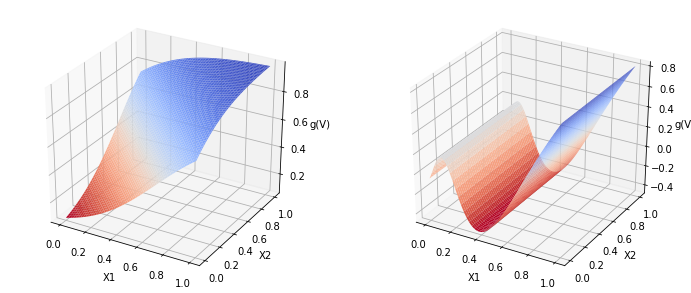

In [4]:
# //matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
fig = plt.figure(0, figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf_left = ax1.plot_surface(x, y, z_left, cmap=cm.coolwarm_r)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('g(V)')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf_right = ax2.plot_surface(x, y, z_right, cmap=cm.coolwarm_r)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('g(V)')
plt.show()

### The power of PPR models

The PPR model

\begin{equation}
f(X) = \sum_{m=1}^M g_m(\omega_m^T X).
\end{equation}

is very general, since the operation of forming nonlinear functions of llinear combinations generates a surprisingly large class of models.

For example, the product $X_1\cdot X_2$ can be written as

\begin{equation}
X_1\cdot X_2 = \left[ (X_1+X_2)^2 - (X_1-X_2)^2 \right]/4,
\end{equation}

and higher-order products can be represented similarly.

In fact, if $M$ is taken arbitrarily large, for appropriate choice of $g_m$ the PPR model can approximate any continuous function in $\mathbb{R}^p$ arbitrarily well. Such a class of models is called a _universal approximator_.

However this generality comes at a price. Interpretation of the fitted model is usually difficult, because each input enters into the model in a complex and multifaceted way.

> As a result, the PPR model is most useful for prediction, and not very useful for producing an understandable model for the data.

The $M=1$ model, known as the _single index model_ in econometric, is an exception. It is slightly more general than the linear regression model, and offers a similar interpretation.

### How to fit

Given training data $(x_i,y_i)$, $i=1,2,\cdots,N$, we seek the approximate minimizers of the error function

\begin{equation}
\sum_{i=1}^N \left[ y_i - \sum_{m=1}^M g_m(\omega_m^T x_i) \right]^2
\end{equation}

over functions $g_m$ and direction vectors $\omega_m$, $m=1,2,\cdots,M$.

As in other smoothing problems, we need either explicitly or implicitly to impose complexity constraints on the $g_m$, to avoid overfit solutions.

### Consider just one term $M=1$.

#### Fix $\omega$, find $g$
Given the direction vector $\omega$, we form the derived variables $v_i = \omega^T x_i$. Then we have a 1D smoothing problem, and we can apply any scatterplot smoother, such as a smoothing spline, to obtain an estimate $g$.

#### Fix $g$, find $\omega$
On the other hand, given $g$, we want to minimize the above error function over $\omega$. A Gauss-Newton search is convenient for this task. This is a quasi-Newton method, in which the part of the Hessian involving the second derivative of $g$ is discarded.

It can be simply derived as follows. Let $\omega_\text{old}$ be the current estimate for $\omega$. We write

\begin{equation}
g(\omega^T x_i) \approx g(\omega_\text{old}^T x_i) + g'(\omega_\text{old}^T x_i)(\omega - \omega_\text{old}^T x_i)
\end{equation}

to give

\begin{equation}
\sum_{i=1}^N \left[ y_i - g(\omega^T x_i) \right]^2 \approx \sum_{i=1}^N g'(\omega_\text{old}^T x_i)^2 \left[\left( \omega_\text{old}^T x_i + \frac{y_i - g(\omega_\text{old}^T x_i)}{g'(\omega_\text{old}^T x_i)} \right) - \omega^T x_i \right]^2.
\end{equation}

To minimize this, we carry out a least squares regression with target

\begin{equation}
\omega_\text{old}^T x_i + \frac{y_i - g(\omega_\text{old}^T x_i)}{g'(\omega_\text{old}^T x_i)}
\end{equation}

on the input $x_i$, with weights $g'(\omega_\text{old} x_i)^2$ and no intercept (bias) term. This produces the updated coefficient vector $\omega_\text{new}$.

#### Together
These two steps, estimation of $g$ and $\omega$, are iterated until convergence.

With more than one term in the PPR model, the model is built in a forward stage-wise manner, adding a pair $(\omega_m, g_m)$ at each stage.

### Implementation details

* Although any smoothing method can in principle be used, it is convenient if the method provides derivatives. Local regression and smoothing splines are convenient.
* After each step the $g_m$ from previous steps can be readjusted using the backfitting procedure (Chapter 9). While this may lead ultimately to fewer term, it is not clear whether it improves predicton performance.
* Usually the $\omega_m$ are not readjusted (partly to avoid excessive computation), although in principle they could be as well.
* The number of terms $M$ is usually estimated as part of the forward stage-wise strategy. The model building stops when the next term does not appreciably improve the fit of the model. Cross-validation can also be used to determine $M$.

### Applications

* Density estimation (Friedman et al., 1984; Friedman, 1987) where the projection pursuit idea can be used.
* See the discussion of ICA in $\S$ 14.7 and its relationship with exploratory projection pursuit.

However, the projection pursuit regression model has not been widely used in the field of statistics, perhaps becuase at the time of its introduction (1981), its computational demands exceeded the capabilities of most readily available computers.

But it does represent an important intellectual advance, one that has blossomed in its reincarnation in the field of neural networks.